# VTNet Leave-One-User-Out Evaluation on Non-Contaminated Dataset



In [1]:
import os
from pathlib import Path
from functools import lru_cache

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
)



In [ ]:
# GPU configuration and diagnostics
print(f"TensorFlow version: {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("\n=== GPU Diagnostics ===")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")
try:
    print(f"CUDA available: {tf.test.is_gpu_available(cuda_only=True)}")
except:
    print("CUDA availability check failed (method may be deprecated)")

print(f"\nPhysical devices: {tf.config.list_physical_devices()}")
print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")

# Check for CUDA/cuDNN libraries
if tf.config.list_physical_devices('GPU'):
    print("\n✅ GPU detected! TensorFlow can use your GPU.")
    # Configure GPU memory growth to avoid allocating all memory
    try:
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(f"Warning: Could not configure GPU memory growth: {e}")
else:
    print("\n❌ No GPU detected by TensorFlow.")
    print("\nPossible solutions:")
    print("1. Install/update CUDA toolkit (TensorFlow 2.18.1 requires CUDA 12.x)")
    print("2. Install cuDNN library compatible with your CUDA version")
    print("3. Make sure CUDA/bin and cuDNN are in your PATH")
    print("4. Restart your Jupyter kernel after installing CUDA/cuDNN")
    print("5. Try: pip install tensorflow[and-cuda] (includes CUDA dependencies)")
    print("\nYour system shows CUDA 12.9 via nvidia-smi, but TensorFlow may need:")
    print("- CUDA toolkit installed (not just drivers)")
    print("- cuDNN library in PATH")
    print("- Compatible TensorFlow build")



TensorFlow version: 2.10.1
Num GPUs Available:  1

=== GPU Diagnostics ===
Built with CUDA: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [2]:
# Paths and configuration (resolve relative to this notebook)
def find_project_root(start: Path, marker: str = "non-contaminated datasets", max_levels: int = 6) -> Path:
    current = start.resolve()
    for _ in range(max_levels):
        if (current / marker).exists():
            return current
        current = current.parent
    raise FileNotFoundError(f"Could not locate project root containing '{marker}' starting from {start}")

current_dir = Path.cwd()
try:
    base_dir = find_project_root(current_dir)
except FileNotFoundError as e:
    print(e)
    base_dir = current_dir  # fallback to current directory

scanpaths_dir = base_dir / "non-contaminated datasets" / "Scanpaths"
raw_csv_dir = base_dir / "non-contaminated datasets" / "Raw Eye Tracking Data"
target_csv_path = base_dir / "Code" / "Utilities" / "users_literacy_results.csv"

print(f"Working directory: {current_dir}")
print(f"Project root: {base_dir}")
print(f"Scanpaths dir exists: {scanpaths_dir.exists()}")
print(f"Raw CSV dir exists: {raw_csv_dir.exists()}")
print(f"Target CSV path: {target_csv_path}")

# Data constants
IMG_HEIGHT = 150
IMG_WIDTH = 150
SEQ_LENGTH = 150
BATCH_SIZE = 16
EPOCHS = 12
VALIDATION_SPLIT = 0.1
RANDOM_SEED = 42

skip_users = {5, 20}
graph_types = ["bar", "line", "pie"]
class_map = {"illiterate": 0, "literate": 1}
label_names = ["illiterate", "literate"]

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)



Working directory: c:\Users\hapii4u\Desktop\Hapii Lab\Tony Gonzalez\LOUO CV
Project root: C:\Users\hapii4u\Desktop\Hapii Lab\Tony Gonzalez
Scanpaths dir exists: True
Raw CSV dir exists: True
Target CSV path: C:\Users\hapii4u\Desktop\Hapii Lab\Tony Gonzalez\Code\Utilities\users_literacy_results.csv


In [3]:
# Load literacy labels for reference
literacy_df = pd.read_csv(target_csv_path)
literacy_df["MEDIA_ID"] = literacy_df["MEDIA_ID"].astype(int)
literacy_df["LITERACY"] = literacy_df["LITERACY"].astype(int)
literacy_map = dict(zip(literacy_df["MEDIA_ID"], literacy_df["LITERACY"]))



In [4]:
def parse_user_id(path: Path) -> int:
    """Extract user ID from a path segment like user_12."""
    name = path.name
    if name.startswith("user_"):
        try:
            return int(name.split("_")[1])
        except (IndexError, ValueError):
            return None
    return None


def parse_question_id(filename: str) -> int:
    """Extract question number from filenames like user_1_question_23_scanpath.png."""
    try:
        part = filename.split("question_")[1]
        return int(part.split("_")[0].split(".")[0])
    except (IndexError, ValueError):
        return None



In [5]:
def load_timeseries_from_csv(csv_path: Path, max_length: int = SEQ_LENGTH) -> np.ndarray:
    """Load and preprocess gaze coordinates and pupil data from CSV."""
    try:
        df = pd.read_csv(csv_path)
        # Extract 6 columns: FPOGX, FPOGY, LPS, RPS, LPMM, RPMM
        data = df[["FPOGX", "FPOGY", "LPS", "RPS", "LPMM", "RPMM"]].values.astype(np.float32)
        data = data[~np.isnan(data).any(axis=1)]
    except Exception:
        data = np.zeros((0, 6), dtype=np.float32)

    if data.shape[0] >= max_length:
        data = data[-max_length:]
    else:
        pad_len = max_length - data.shape[0]
        padding = np.zeros((pad_len, 6), dtype=np.float32)
        data = np.vstack([padding, data])
    return data.astype(np.float32)



In [6]:
def collect_samples_for_graph(graph_type: str):
    """Collect all scanpath/csv pairs for a given graph type."""
    samples = []
    graph_scan_dir = scanpaths_dir / graph_type
    graph_csv_dir = raw_csv_dir / graph_type

    for literacy_name, label in class_map.items():
        scan_class_dir = graph_scan_dir / literacy_name
        csv_class_dir = graph_csv_dir / literacy_name
        if not scan_class_dir.exists():
            continue

        for user_dir in sorted(scan_class_dir.glob("user_*")):
            user_id = parse_user_id(user_dir)
            if user_id is None or user_id in skip_users:
                continue

            csv_user_dir = csv_class_dir / f"user_{user_id}"
            if not csv_user_dir.exists():
                continue

            for img_path in sorted(user_dir.glob("*.png")):
                question_id = parse_question_id(img_path.name)
                csv_name = img_path.stem.replace("_scanpath", "") + ".csv"
                csv_path = csv_user_dir / csv_name
                if not csv_path.exists():
                    continue

                samples.append(
                    {
                        "image": img_path,
                        "csv": csv_path,
                        "label": label,
                        "user_id": user_id,
                        "question_id": question_id,
                    }
                )
    return samples



In [7]:
def _py_load_timeseries(path_tensor):
    if hasattr(path_tensor, "numpy"):
        path_bytes = path_tensor.numpy()
    else:
        path_bytes = path_tensor
    if isinstance(path_bytes, bytes):
        path_str = path_bytes.decode("utf-8")
    else:
        path_str = str(path_bytes)
    return load_timeseries_from_csv(Path(path_str))


def make_dataset(samples, shuffle=False, batch_size=BATCH_SIZE):
    if len(samples) == 0:
        raise ValueError("No samples provided to build dataset.")

    image_paths = [str(s["image"]) for s in samples]
    csv_paths = [str(s["csv"]) for s in samples]
    labels = [s["label"] for s in samples]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, csv_paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(samples), reshuffle_each_iteration=True)

    def load_sample(image_path, csv_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        image = tf.image.rgb_to_grayscale(image)
        image = tf.cast(image, tf.float32) / 255.0

        timeseries = tf.py_function(func=_py_load_timeseries, inp=[csv_path], Tout=tf.float32)
        timeseries.set_shape((SEQ_LENGTH, 6))

        label_onehot = tf.one_hot(label, depth=2)
        return (image, timeseries), label_onehot

    dataset = dataset.map(load_sample, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset



In [8]:
def create_vtnet_model(rnn_type="gru", hidden_size=256):
    scanpath_input = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name="scanpath_input")
    timeseries_input = tf.keras.layers.Input(shape=(SEQ_LENGTH, 6), name="timeseries_input")

    # CNN branch
    x = tf.keras.layers.Conv2D(6, (5, 5), activation="relu", name="conv1")(scanpath_input)
    x = tf.keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = tf.keras.layers.Conv2D(16, (5, 5), activation="relu", name="conv2")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name="pool2")(x)
    x = tf.keras.layers.Flatten(name="cnn_flatten")(x)
    cnn_features = tf.keras.layers.Dense(50, activation="relu", name="cnn_fc1")(x)

    # RNN branch
    if rnn_type.lower() == "gru":
        rnn_layer = tf.keras.layers.GRU(hidden_size, name="rnn_gru")
    elif rnn_type.lower() == "lstm":
        rnn_layer = tf.keras.layers.LSTM(hidden_size, name="rnn_lstm")
    else:
        rnn_layer = tf.keras.layers.SimpleRNN(hidden_size, name="rnn_simple")

    rnn_features = rnn_layer(timeseries_input)

    fused = tf.keras.layers.Concatenate(name="fusion_concat")([cnn_features, rnn_features])
    fused = tf.keras.layers.Dense(20, activation="relu", name="fusion_fc1")(fused)
    output = tf.keras.layers.Dense(2, activation="softmax", name="output")(fused)

    model = tf.keras.models.Model(inputs=[scanpath_input, timeseries_input], outputs=output, name="VTNet_LOUO")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model



In [9]:
def run_fold(train_samples, test_samples, epochs=EPOCHS):
    # Split train into train/val
    test_size = max(1, int(len(train_samples) * VALIDATION_SPLIT))
    labels = [s["label"] for s in train_samples]
    n_classes = len(set(labels))
    
    # Only use stratification if test_size is large enough
    # Stratification requires test_size >= n_classes
    use_stratify = test_size >= n_classes
    
    train_paths, val_paths = train_test_split(
        train_samples,
        test_size=test_size,
        random_state=RANDOM_SEED,
        stratify=labels if use_stratify else None,
    )

    train_ds = make_dataset(train_paths, shuffle=True, batch_size=BATCH_SIZE)
    val_ds = make_dataset(val_paths, shuffle=False, batch_size=BATCH_SIZE)
    test_ds = make_dataset(test_samples, shuffle=False, batch_size=BATCH_SIZE)

    model = create_vtnet_model()

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=0,
    )

    # Evaluate on test user
    y_true = []
    y_pred = []

    for (images, timeseries), labels in test_ds:
        preds = model.predict([images, timeseries], verbose=0)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
    }
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="binary",
        zero_division=0,
    )
    metrics.update({"precision": precision, "recall": recall, "f1": f1})
    metrics["confusion_matrix"] = confusion_matrix(y_true, y_pred, labels=[0, 1])

    return metrics, history.history, y_true, y_pred



In [10]:
def run_louo_for_graph(graph_type: str):
    samples = collect_samples_for_graph(graph_type)
    if len(samples) == 0:
        raise ValueError(f"No samples found for graph type {graph_type}")

    df = pd.DataFrame(samples)
    user_ids = sorted(df["user_id"].unique())

    overall_true = []
    overall_pred = []
    fold_results = {}

    for user_id in user_ids:
        train_samples = df[df["user_id"] != user_id].to_dict("records")
        test_samples = df[df["user_id"] == user_id].to_dict("records")

        if len(test_samples) == 0 or len(train_samples) == 0:
            continue

        metrics, history, y_true, y_pred = run_fold(train_samples, test_samples)

        fold_results[user_id] = {
            "metrics": metrics,
            "history": history,
        }

        overall_true.extend(y_true)
        overall_pred.extend(y_pred)

    precision, recall, f1, _ = precision_recall_fscore_support(
        overall_true,
        overall_pred,
        average="binary",
        zero_division=0,
    )

    aggregate = {
        "accuracy": accuracy_score(overall_true, overall_pred),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": confusion_matrix(overall_true, overall_pred, labels=[0, 1]),
        "folds": fold_results,
    }

    return aggregate



In [11]:
results = {}

for graph in graph_types:
    print(f"\n=== Running VTNet LOUO for {graph} graphs ===")
    results[graph] = run_louo_for_graph(graph)
    agg = results[graph]
    print(
        f"Accuracy: {agg['accuracy']:.3f} | Precision: {agg['precision']:.3f} | "
        f"Recall: {agg['recall']:.3f} | F1: {agg['f1']:.3f}"
    )




=== Running VTNet LOUO for bar graphs ===
Accuracy: 0.461 | Precision: 0.325 | Recall: 0.220 | F1: 0.262

=== Running VTNet LOUO for line graphs ===
Accuracy: 0.558 | Precision: 0.491 | Recall: 0.322 | F1: 0.389

=== Running VTNet LOUO for pie graphs ===
Accuracy: 0.438 | Precision: 0.417 | Recall: 0.714 | F1: 0.526


In [12]:
summary_df = pd.DataFrame(
    [
        {
            "graph_type": graph,
            "accuracy": res["accuracy"],
            "precision": res["precision"],
            "recall": res["recall"],
            "f1": res["f1"],
        }
        for graph, res in results.items()
    ]
).sort_values("graph_type")
summary_df



,graph_type,accuracy,precision,recall,f1
0,bar,0.460957,0.324786,0.219653,0.262069
1,line,0.557789,0.491228,0.321839,0.388889
2,pie,0.437500,0.416667,0.714286,0.526316


In [13]:
graph_type = "bar"

fold_rows = []
for user_id, info in results.get(graph_type, {}).get("folds", {}).items():
    m = info["metrics"]
    fold_rows.append(
        {
            "user_id": user_id,
            "accuracy": m["accuracy"],
            "precision": m["precision"],
            "recall": m["recall"],
            "f1": m["f1"],
        }
    )

pd.DataFrame(fold_rows).sort_values("user_id")



,user_id,accuracy,precision,recall,f1
0,1,0.000000,0.0,0.000000,0.000000
1,2,1.000000,0.0,0.000000,0.000000
2,3,0.000000,0.0,0.000000,0.000000
3,4,0.500000,1.0,0.500000,0.666667
4,6,1.000000,0.0,0.000000,0.000000
5,7,0.461538,0.0,0.000000,0.000000
6,8,0.333333,1.0,0.333333,0.500000
7,9,0.000000,0.0,0.000000,0.000000
8,10,0.062500,1.0,0.062500,0.117647
9,11,0.937500,0.0,0.000000,0.000000


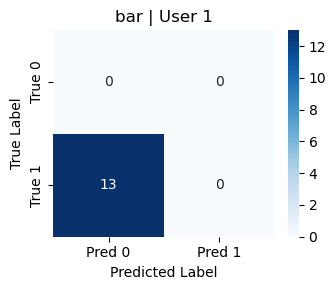

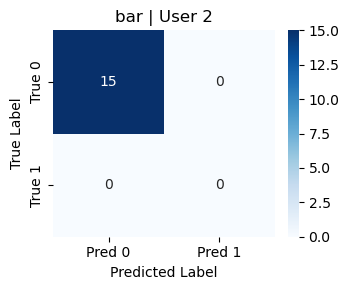

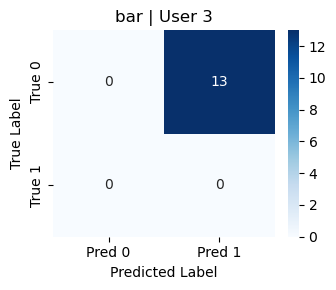

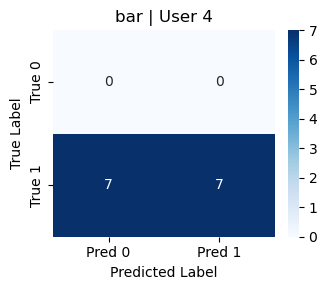

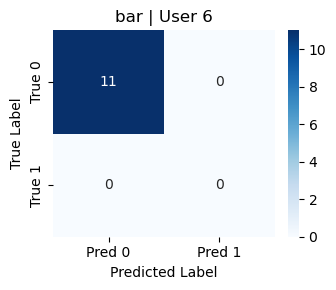

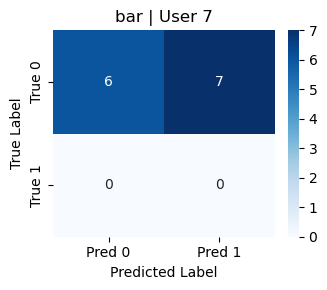

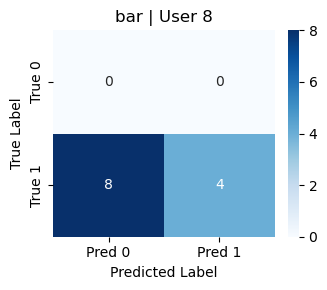

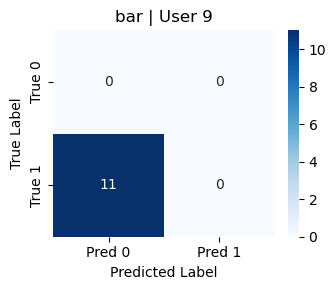

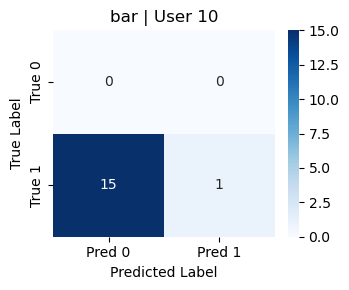

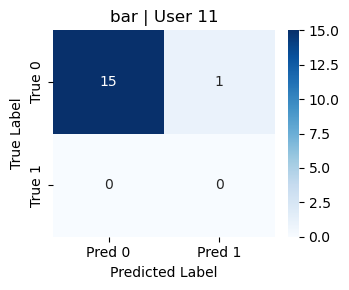

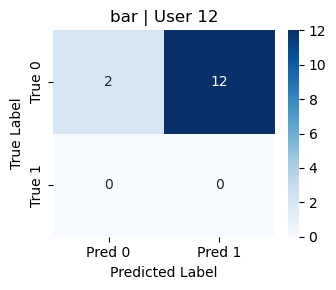

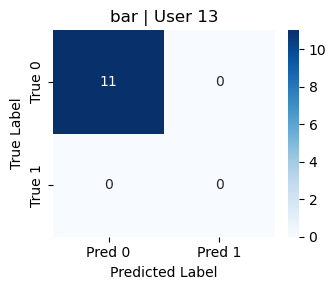

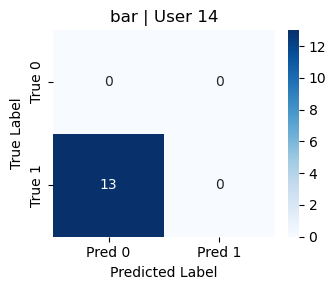

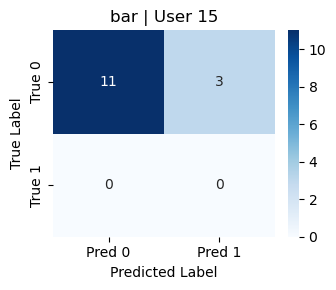

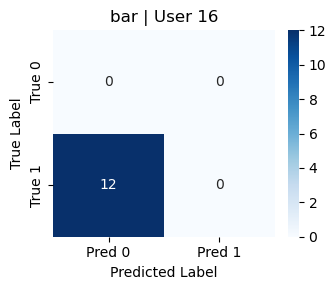

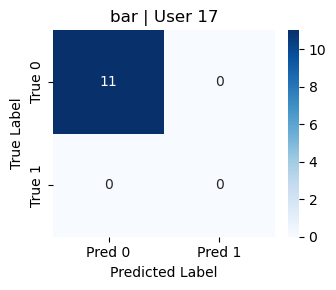

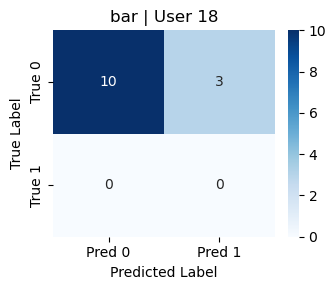

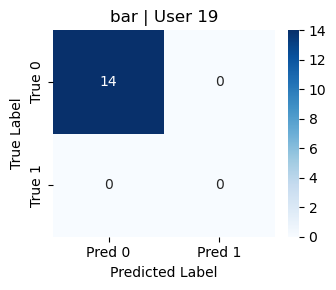

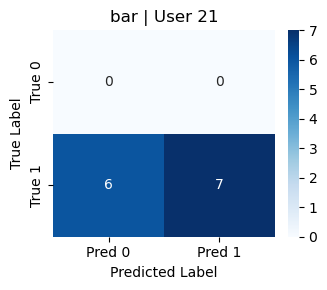

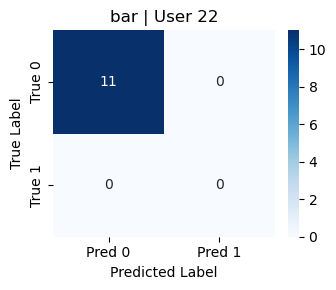

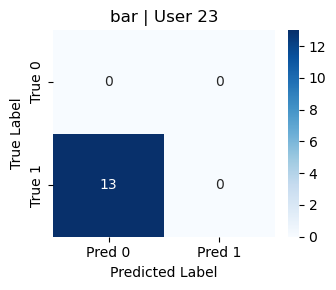

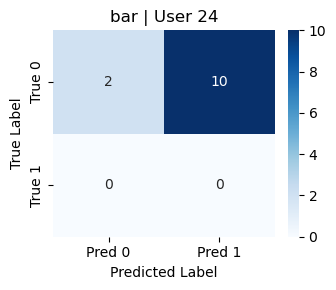

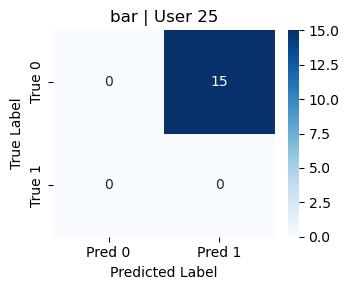

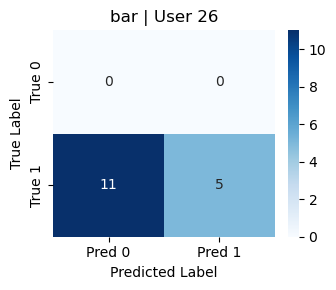

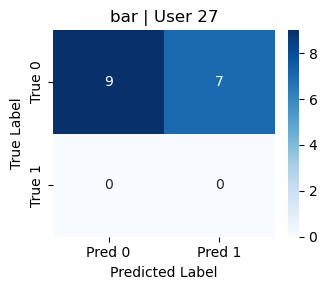

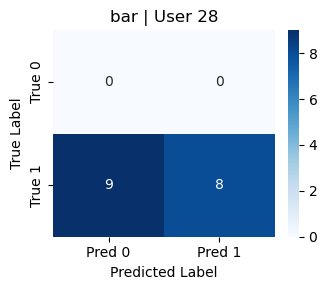

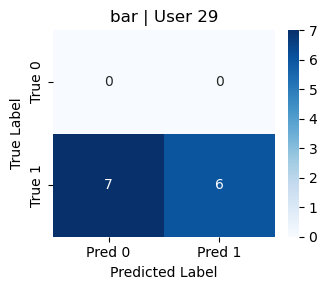

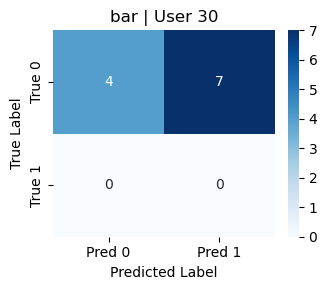

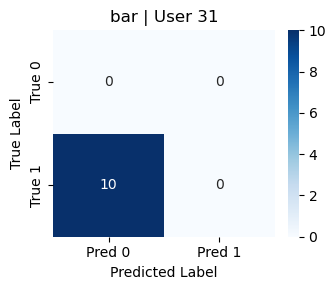

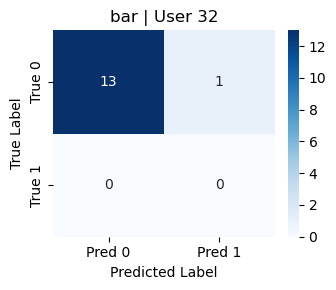

In [14]:
graph_type = "bar"

if graph_type in results:
    for user_id, info in results[graph_type]["folds"].items():
        cm = info["metrics"]["confusion_matrix"]
        plt.figure(figsize=(3.5, 3))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"],
        )
        plt.title(f"{graph_type} | User {user_id}")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.tight_layout()
        plt.show()
else:
    print(f"Graph type '{graph_type}' not in results.")



In [15]:
# Calculate new accuracy based on user-level binary classification
# For each user: if accuracy > 0.5, count as correct; if <= 0.5, count as wrong
# Then calculate accuracy as (correct users) / (total users) for each graph type

user_level_accuracy = {}

for graph_type in graph_types:
    if graph_type not in results:
        continue
    
    correct_users = 0
    total_users = 0
    user_details = []
    
    for user_id, info in results[graph_type]["folds"].items():
        user_acc = info["metrics"]["accuracy"]
        total_users += 1
        
        if user_acc > 0.5:
            correct_users += 1
            user_details.append({
                "user_id": user_id,
                "accuracy": user_acc,
                "correct": True
            })
        else:
            user_details.append({
                "user_id": user_id,
                "accuracy": user_acc,
                "correct": False
            })
    
    new_accuracy = correct_users / total_users if total_users > 0 else 0.0
    user_level_accuracy[graph_type] = {
        "new_accuracy": new_accuracy,
        "correct_users": correct_users,
        "total_users": total_users,
        "user_details": user_details
    }
    
    print(f"{graph_type} graphs:")
    print(f"  New Accuracy: {new_accuracy:.3f} ({correct_users}/{total_users} users)")
    print()

# Create summary DataFrame
summary_user_level = pd.DataFrame([
    {
        "graph_type": graph,
        "new_accuracy": info["new_accuracy"],
        "correct_users": info["correct_users"],
        "total_users": info["total_users"]
    }
    for graph, info in user_level_accuracy.items()
]).sort_values("graph_type")

print("Summary:")
summary_user_level


bar graphs:
  New Accuracy: 0.400 (12/30 users)

line graphs:
  New Accuracy: 0.500 (15/30 users)

pie graphs:
  New Accuracy: 0.467 (7/15 users)

Summary:


,graph_type,new_accuracy,correct_users,total_users
0,bar,0.400000,12,30
1,line,0.500000,15,30
2,pie,0.466667,7,15
